In [1]:
from orgpackage.aux import load_experiments
import pandas as pd

%load_ext autoreload
%autoreload 2

# 1. RULES

In [37]:
df = load_dataset()

Loaded dataset with 182519 unique instances


In [36]:
print(len(df))
print(len(df['instance'].unique()))

182573
182519


In [34]:
data= pd.read_csv('./data/wikidata_enriched_dataset.csv')
print(data.shape[0])

182537


# Country Rule Scores

In [73]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from orgpackage.aux import load_dataset
from orgpackage.config import COUNTRY_DICT, DOMAIN_CLASSES_CORR
import matplotlib.colors as mcolors

# -----------------------------------------------------
# STEP 1: Build volume_dict (per domain, per country, per class)
# -----------------------------------------------------
volume_dict = {}
final_df = load_dataset()
# If load_dataset() returns a list, concatenate the dataframes.
if isinstance(final_df, list):
    final_df = pd.concat(final_df, ignore_index=True)

for domain in DOMAIN_CLASSES_CORR:
    volume_dict[domain] = {}
    for country in COUNTRY_DICT:
        volume_dict[domain][country] = {}
        country_df = final_df[final_df['country'] == country]
        for cls in DOMAIN_CLASSES_CORR[domain]:
            volume_dict[domain][country][cls] = country_df[country_df[cls] == 1].shape[0]
#print(volume_dict)  # Uncomment if you want to see the output

Loaded dataset with 182519 unique instances


In [74]:
exps = load_experiments()
print(exps['Parameters'])
def extract_country_f1(row):
    params = row['Parameters']
    
    # If params is already a dictionary
    if isinstance(params, dict):
        return params.get('country_f1', 'None')
    
    # If params is a string representation of a dictionary
    elif isinstance(params, str):
        try:
            import ast
            dict_params = ast.literal_eval(params)
            return dict_params.get('country_f1', 'None')
        except:
            return 'None'
    
    # For any other case
    return 'None'

exps['country_f1'] = exps.apply(extract_country_f1, axis=1)

0     {'structure': 'nested-class', 'keywords': {'wh...
1     {'structure': 'nested-class', 'token_num': 5, ...
2     {'structure': '2-class', 'token_num': 5, 'keyw...
3     {'structure': '3-multiclass', 'token_num': 5, ...
4     {'structure': '3-class', 'preprocessing': 'Non...
                            ...                        
95    {'structure': 'nested-class', 'model': 'e5-sma...
96    {'structure': '2-class', 'model': 'e5-small', ...
97    {'structure': '2-class', 'model': 'e5-small', ...
98    {'structure': '3-multiclass', 'model': 'mistra...
99    {'structure': '3-multiclass', 'model': 'e5-sma...
Name: Parameters, Length: 100, dtype: object


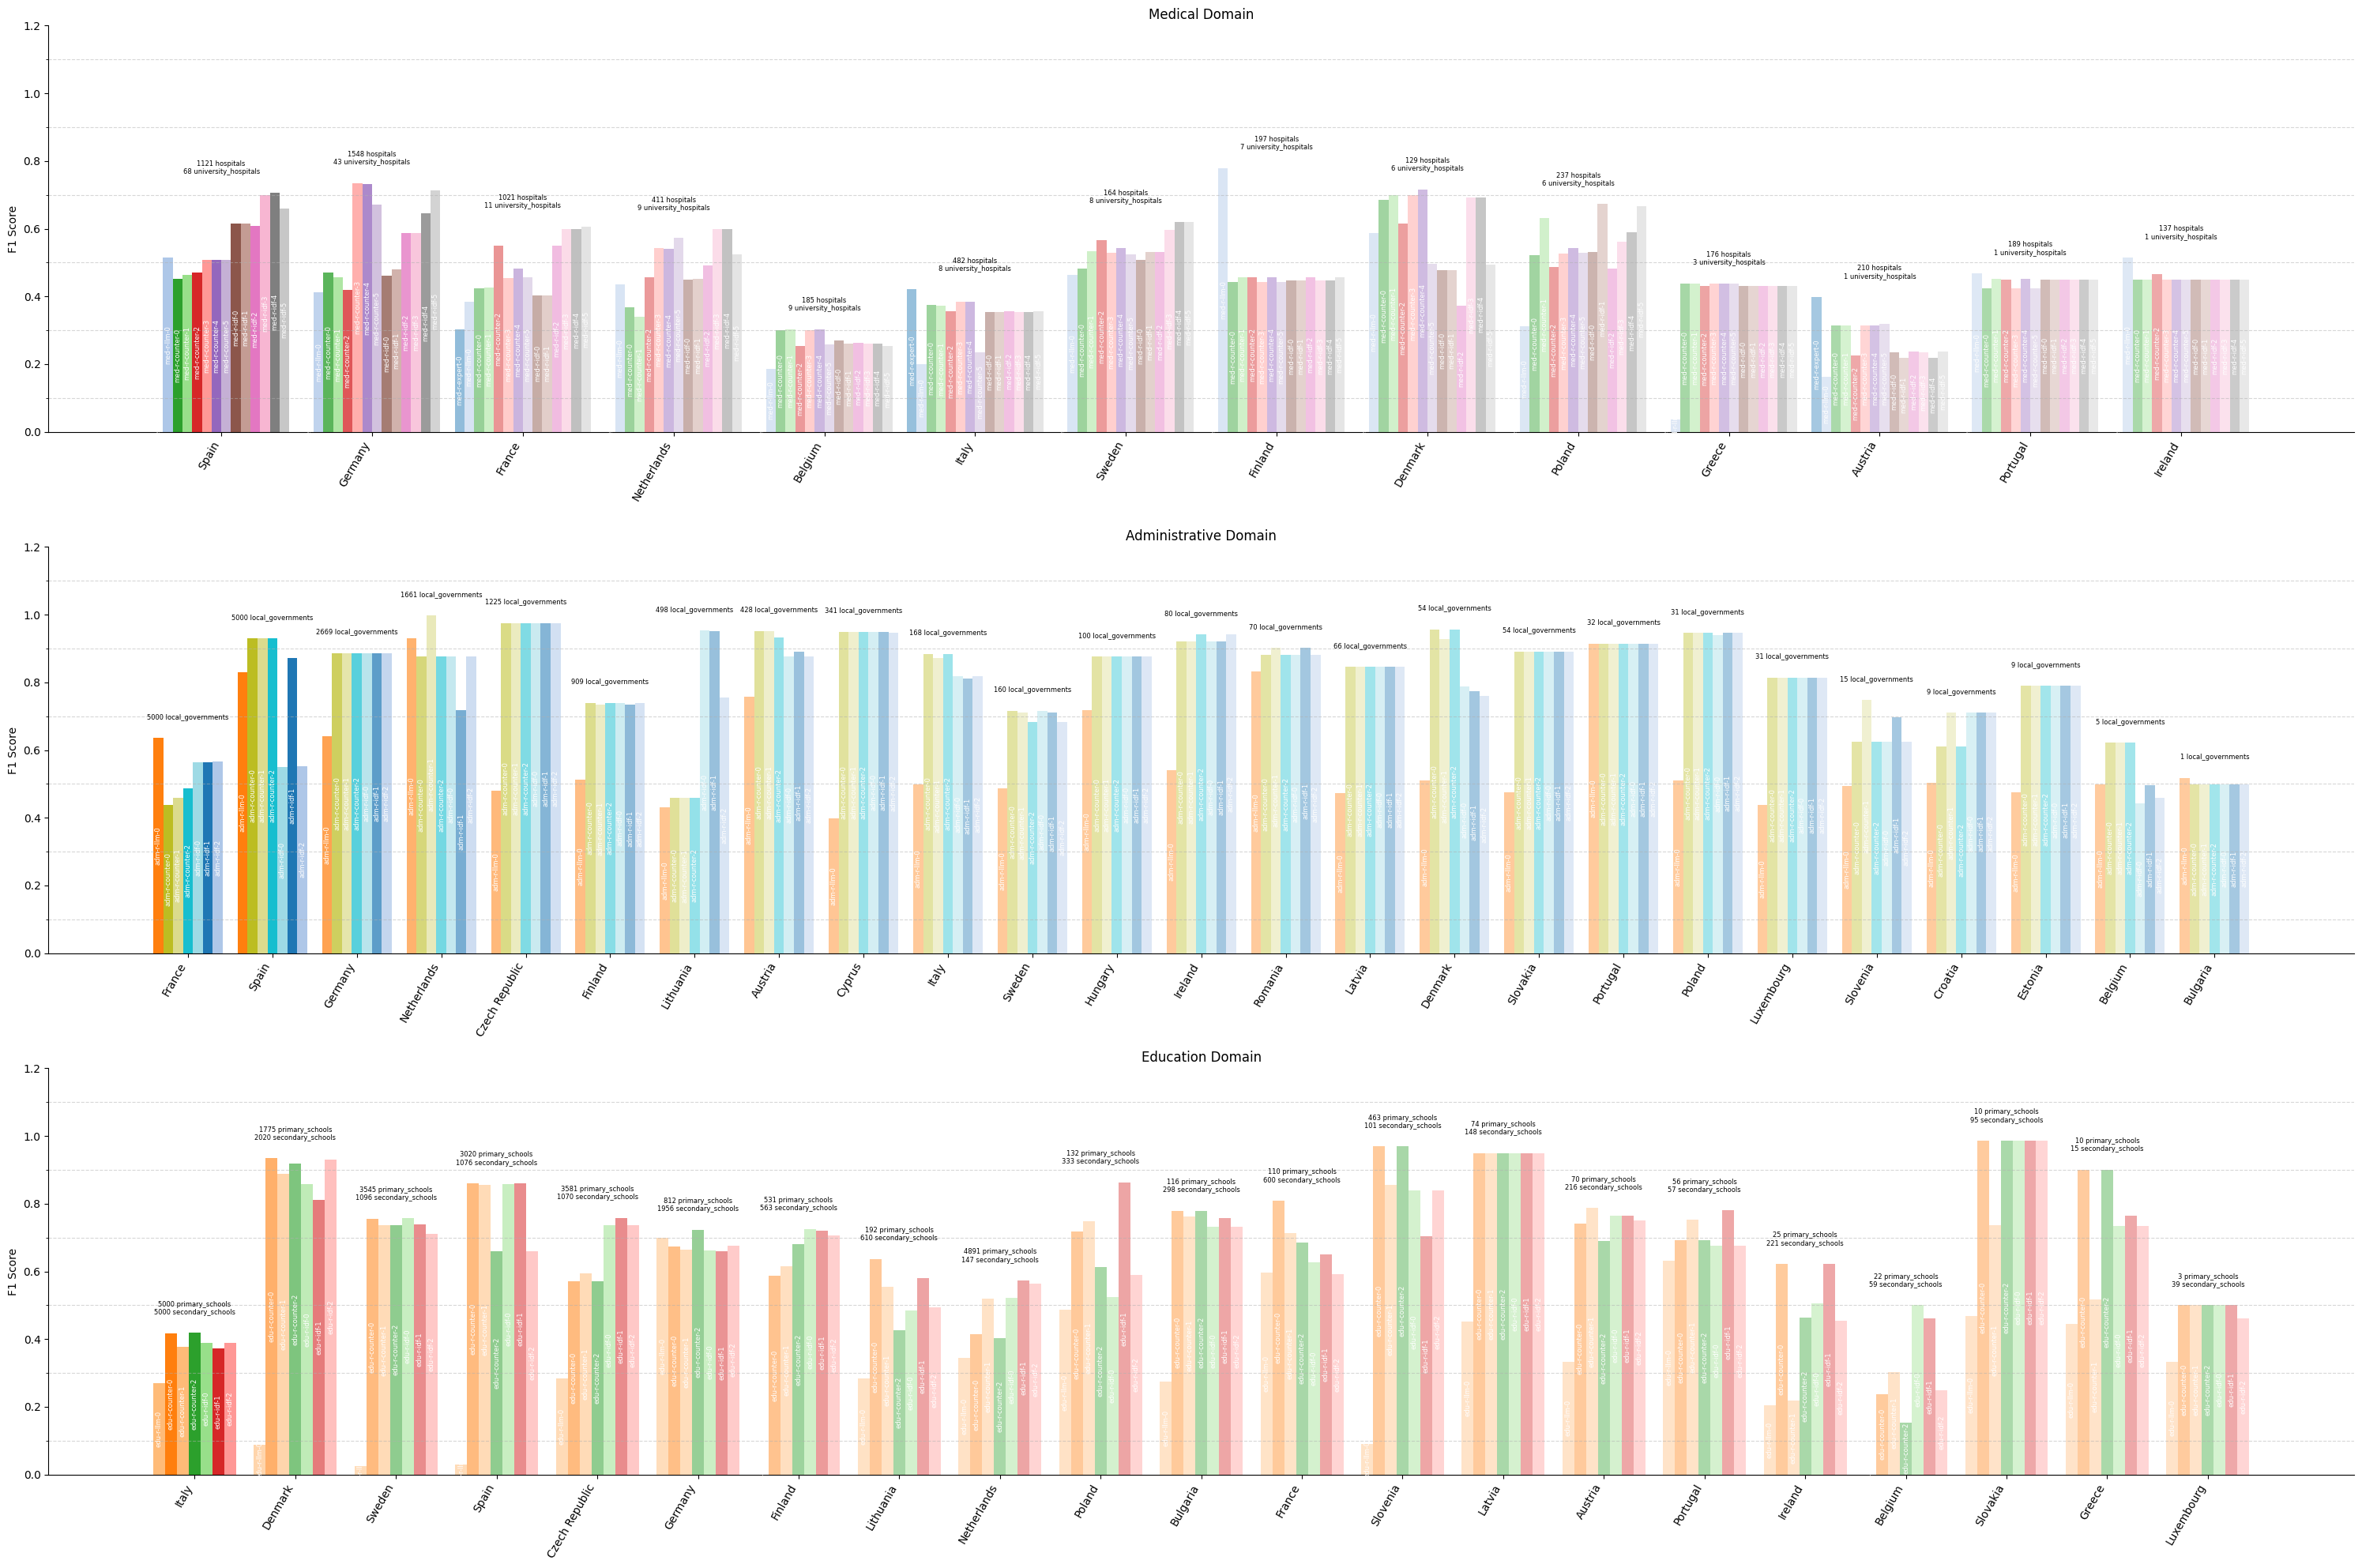

In [76]:


# -----------------------------------------------------
# STEP 2: Prepare country-level F1 data for plotting
# -----------------------------------------------------
# Extract country-level F1 scores per experiment.
valid_exps = exps[exps['country_f1'].notnull()].copy()
records = []
for _, row in valid_exps.iterrows():
    domain = row['Domain']
    exp_id = row['ID']
    country_scores = row['country_f1']
    if isinstance(country_scores, dict):
        for country, f1 in country_scores.items():
            if f1 is not None:
                records.append({
                    'Domain': domain,
                    'Country': country,
                    'Experiment': exp_id,
                    'F1': f1
                })
long_df = pd.DataFrame(records)

# -----------------------------------------------------
# STEP 3: Set up plotting parameters and prepare base volumes per country.
# -----------------------------------------------------
# (We no longer use the overall country_volume from the dataset volume; instead we use
#  the per-domain, per-country min count among classes from volume_dict.)
# For ordering countries, we can sort by the minimum count (of classes) per country in the domain.
domains = long_df['Domain'].unique()
experiment_ids = long_df['Experiment'].unique()
color_map = {eid: plt.cm.tab20(i % 20) for i, eid in enumerate(experiment_ids)}

# Create the figure (one subplot per domain)
fig, ax = plt.subplots(len(domains), 1, figsize=(30, 7 * len(domains)))

if len(domains) == 1:
    ax = [ax]

# Constant bar width for all bars
constant_width = 2

# -----------------------------------------------------
# STEP 4: Plot each domain and integrate volume data and opacity.
# -----------------------------------------------------
for i, domain in enumerate(domains):
    domain_df = long_df[long_df['Domain'] == domain]
    # Get the list of countries that have data in this domain.
    # We will sort by the minimum available volume among classes for each country.
    countries = sorted(
        domain_df['Country'].unique(),
        key=lambda c: min(volume_dict[domain].get(c, {}).values()) if volume_dict[domain].get(c, {}) else 0,
        reverse=True
    )
    
    # For opacity, use the minimum volume per country (the selected class is the one with the lowest volume)
    country_min_vols = []
    for country in countries:
        # Handle case if no classes found for a country; default to 0
        if volume_dict[domain].get(country, {}):
            country_min_vols.append(min(volume_dict[domain][country].values()))
        else:
            country_min_vols.append(0)
    
    if country_min_vols:
        domain_min_vol = min(country_min_vols)
        domain_max_vol = max(country_min_vols)
    else:
        domain_min_vol = domain_max_vol = 0

    def get_alpha(country, min_a=0.4, max_a=1.0):
        vol = min(volume_dict[domain][country].values()) if volume_dict[domain].get(country, {}) else 0
        if domain_max_vol == domain_min_vol:
            return min_a
        return min_a + (max_a - min_a) * ((vol - domain_min_vol) / (domain_max_vol - domain_min_vol))
    
    current_x = 0
    xpos = []
    f1_scores = []
    colors = []
    labels = []
    ticks = []
    group_spacing = 3
    
    # For storing annotation info per country group:
    # (group_center, group_max, annotation_text)
    annotations = []

    for country in countries:
        group = domain_df[domain_df['Country'] == country]
        alpha_value = get_alpha(country)
        group_xs = []

        # For each bar (experiment result) in this country group.
        for _, row in group.iterrows():
            xpos.append(current_x)
            f1_scores.append(row['F1'])
            base_color = color_map.get(row['Experiment'], mcolors.to_rgba('gray'))
            if not isinstance(base_color, tuple):
                base_color = mcolors.to_rgba(base_color)
            rgba_color = (base_color[0], base_color[1], base_color[2], alpha_value)
            colors.append(rgba_color)
            labels.append(row['Experiment'])
            group_xs.append(current_x)
            current_x += constant_width

        if group_xs:
            # Use the center of the country group for the tick mark.
            ticks.append((np.mean(group_xs), country))
            # Determine the maximum F1 value for vertical positioning.
            group_max = group['F1'].max()
            # Build annotation text: list each class with its number of instances.
            # Format: "ClassA: 100 instances, ClassB: 200 instances, ..."
            country_volume_info = volume_dict[domain].get(country, {})
            annotation_text = "\n".join(f"{count} {cls}s" for cls, count in country_volume_info.items())
            annotations.append((np.mean(group_xs), group_max, annotation_text))
        current_x += group_spacing

    # Plot the bars with uniform width
    for x, height, color in zip(xpos, f1_scores, colors):
        ax[i].bar(x, height, width=constant_width, color=color)

    # Add the experiment label inside each bar (rotated vertically)
    for j, (x, height) in enumerate(zip(xpos, f1_scores)):
        ax[i].text(x, height/2, labels[j], ha='center', va='center', color='white', fontsize=6, rotation=90)

    # Set ticks by country (using COUNTRY_DICT to map the country code to a name if available)
    if ticks:
        tick_positions, raw_labels = zip(*ticks)
        country_names = [COUNTRY_DICT.get(cid, {}).get("country", cid) for cid in raw_labels]
        ax[i].set_xticks(tick_positions)
        ax[i].set_xticklabels(country_names, rotation=60, ha='right')

    ax[i].set_ylabel('F1 Score')
    ax[i].set_title(f'{domain.capitalize()} Domain')

    # Add the volume annotations above each country group.
    for center, group_max, text in annotations:
        # Adjust the text position slightly above the highest bar in the group
        ax[i].text(center, group_max + 0.05, text, ha='center', va='bottom', fontsize=6, color='black')

    ax[i].set_ylim(0, 1.2)                          # Set the y-axis limit from 0 to 1.2
    ax[i].set_yticks(np.arange(0, 1.3, 0.1), minor=True)
    ax[i].spines['top'].set_visible(False)          # Remove the top border
    ax[i].spines['right'].set_visible(False)        # Remove the right border
    ax[i].grid(which='minor', axis='y', linestyle='--', alpha=0.5)

# Optionally, add a legend for the experiment color mapping
handles = [plt.Rectangle((0, 0), 1, 1, color=color_map[eid]) for eid in experiment_ids]
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [102]:

# -----------------------------------------------------
# STEP 2: Prepare country-level F1 data for plotting
# -----------------------------------------------------
# Extract country-level F1 scores per experiment.
valid_exps = exps[exps['country_f1'].notnull()].copy()
# Filter experiments to include only those with 'counter_algorithm' or 'idf_best' methods
valid_exps = valid_exps[valid_exps['Method'].isin(['counter_algorithm', 'idf_best'])]

records = []
for _, row in valid_exps.iterrows():
    domain = row['Domain']
    prep = row['Parameters'].get('preprocessing', 'None')
    exp_id = row['ID']
    method = row['Method']
    country_scores = row['country_f1']
    if isinstance(country_scores, dict):
        for country, f1 in country_scores.items():
            if f1 is not None:
                records.append({
                    'Domain': domain,
                    'Method': method,
                    'Preprocessing': prep,
                    'Country': country,
                    'Experiment': exp_id,
                    'F1': f1
                })
long_df = pd.DataFrame(records)
country_names = [COUNTRY_DICT.get(country_code, {}).get('country', country_code) for country_code in long_df['Country']]
long_df['Country'] = country_names
# Calculate average F1 scores per country and preprocessing
# Reorder the columns in avg_f1_scores to be 'None', 'Spacy tokenization', and 'Decomposition'

avg_f1_scores = long_df.groupby(['Country', 'Preprocessing'])['F1'].mean().unstack()

avg_f1_scores = avg_f1_scores[['None', 'Spacy tokenization', 'Decomposition']]
# Replace the country column by searching for the right name in COUNTRY_DICT



# Calculate the difference between the highest and lowest average F1 scores for each country
avg_f1_scores['Difference (Spacy - None)'] = avg_f1_scores['Spacy tokenization'] - avg_f1_scores['None']


# Sort by the greatest differences between preprocessings
sorted_avg_f1_scores = avg_f1_scores.sort_values(by='Difference (Spacy - None)', ascending=False)

# Display the sorted DataFrame
display(sorted_avg_f1_scores)
# Convert the top 4 entries of the sorted_avg_f1_scores DataFrame to LaTeX format
latex_top_4 = sorted_avg_f1_scores.head(4).to_latex(index=True, float_format="%.2f")
print(latex_top_4)


Preprocessing,None,Spacy tokenization,Decomposition,Difference (Spacy - None)
Country,,,,
Poland,0.658632,0.742727,0.657224,0.084094
Croatia,0.660361,0.710145,0.660361,0.049784
Spain,0.684375,0.726520,0.630562,0.042144
Portugal,0.617779,0.645564,0.621249,0.027785
Romania,0.880696,0.901669,0.880696,0.020973
Netherlands,0.580834,0.592837,0.595940,0.012003
Czech Republic,0.814677,0.825321,0.814677,0.010644
Belgium,0.366473,0.375943,0.313810,0.009471
Sweden,0.632674,0.640637,0.632199,0.007963


\begin{tabular}{lrrrr}
\toprule
Preprocessing & None & Spacy tokenization & Decomposition & Difference (Spacy - None) \\
Country &  &  &  &  \\
\midrule
Poland & 0.66 & 0.74 & 0.66 & 0.08 \\
Croatia & 0.66 & 0.71 & 0.66 & 0.05 \\
Spain & 0.68 & 0.73 & 0.63 & 0.04 \\
Portugal & 0.62 & 0.65 & 0.62 & 0.03 \\
\bottomrule
\end{tabular}



In [103]:
avg_f1_scores = long_df.groupby(['Country', 'Preprocessing'])['F1'].mean().unstack()

avg_f1_scores = avg_f1_scores[['None', 'Spacy tokenization', 'Decomposition']]
# Replace the country column by searching for the right name in COUNTRY_DICT



# Calculate the difference between the highest and lowest average F1 scores for each country
avg_f1_scores['Difference (Decomposition - None)'] = avg_f1_scores['Decomposition'] - avg_f1_scores['None']


# Sort by the greatest differences between preprocessings
sorted_avg_f1_scores = avg_f1_scores.sort_values(by='Difference (Decomposition - None)', ascending=False)

# Display the sorted DataFrame
display(sorted_avg_f1_scores)
# Convert the top 4 entries of the sorted_avg_f1_scores DataFrame to LaTeX format
latex_top_4 = sorted_avg_f1_scores.head(4).to_latex(index=True, float_format="%.2f")
print(latex_top_4)


display(long_df)

Preprocessing,None,Spacy tokenization,Decomposition,Difference (Decomposition - None)
Country,,,,
Germany,0.670223,0.676337,0.695362,0.025139
France,0.539607,0.537397,0.561326,0.021718
Netherlands,0.580834,0.592837,0.595940,0.015106
Finland,0.571333,0.576201,0.583900,0.012567
Portugal,0.617779,0.645564,0.621249,0.003470
Croatia,0.660361,0.710145,0.660361,0.000000
Czech Republic,0.814677,0.825321,0.814677,0.000000
Slovenia,0.763866,0.750896,0.763866,0.000000
Estonia,0.789423,0.789423,0.789423,0.000000


\begin{tabular}{lrrrr}
\toprule
Preprocessing & None & Spacy tokenization & Decomposition & Difference (Decomposition - None) \\
Country &  &  &  &  \\
\midrule
Germany & 0.67 & 0.68 & 0.70 & 0.03 \\
France & 0.54 & 0.54 & 0.56 & 0.02 \\
Netherlands & 0.58 & 0.59 & 0.60 & 0.02 \\
Finland & 0.57 & 0.58 & 0.58 & 0.01 \\
\bottomrule
\end{tabular}



,Domain,Method,Preprocessing,Country,Experiment,F1
0,medical,counter_algorithm,None,France,med-r-counter-0,0.423622
1,medical,counter_algorithm,None,Germany,med-r-counter-0,0.470430
2,medical,counter_algorithm,None,Italy,med-r-counter-0,0.374429
3,medical,counter_algorithm,None,Finland,med-r-counter-0,0.442623
4,medical,counter_algorithm,None,Netherlands,med-r-counter-0,0.367593
...,...,...,...,...,...,...
439,education,idf_best,Decomposition,Slovakia,edu-r-idf-2,0.985714
440,education,idf_best,Decomposition,Slovenia,edu-r-idf-2,0.839806
441,education,idf_best,Decomposition,Luxembourg,edu-r-idf-2,0.461538
442,education,idf_best,Decomposition,Belgium,edu-r-idf-2,0.248804


# Old Rule Scores (TokenNum)

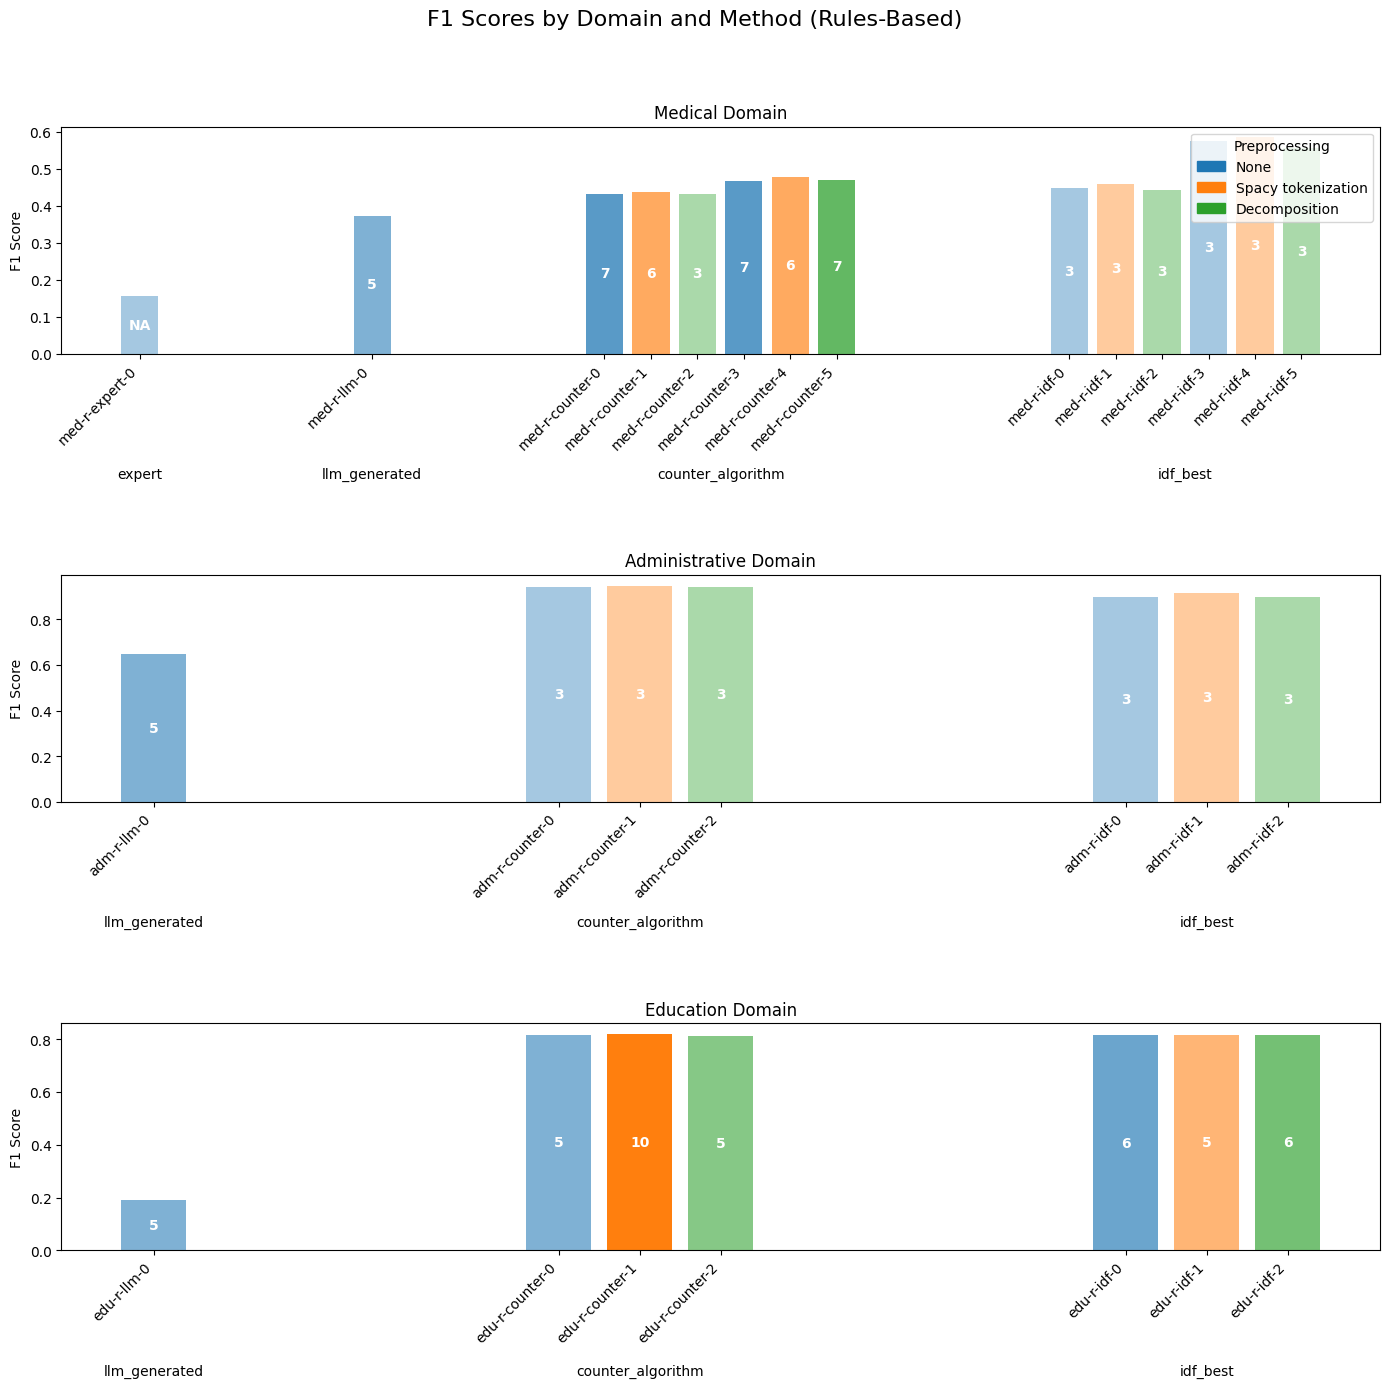

In [47]:

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Filter only rules-based experiments
rules_exps = exps[exps['Technique'] == 'rules']

# Normalize token_num for opacity
def normalize_token_num(val, min_val, max_val):
    if pd.isnull(val):
        return 0.4
    return 0.4 + 0.6 * ((val - min_val) / (max_val - min_val)) if max_val > min_val else 1

token_min = rules_exps['token_num'].min(skipna=True)
token_max = rules_exps['token_num'].max(skipna=True)

# Color map for preprocessing
preprocessing_values = rules_exps['preprocessing'].unique()
color_map = {val: plt.cm.tab10(i) for i, val in enumerate(preprocessing_values)}

# Desired method order
desired_method_order = ['expert', 'llm_generated', 'counter_algorithm', 'idf_best']

# Domains
domains = rules_exps['Domain'].unique()

fig, ax = plt.subplots(len(domains), 1, figsize=(14, 5 * len(domains)))
fig.suptitle('F1 Scores by Domain and Method (Rules-Based)', fontsize=16)

if len(domains) == 1:
    ax = [ax]

for i, domain in enumerate(domains):
    domain_exps = rules_exps[rules_exps['Domain'] == domain]

    # Use custom method order, filtering out missing ones
    methods = [m for m in desired_method_order if m in domain_exps['Method'].values]

    xpos, f1_scores, colors, alphas, x_labels, token_labels = [], [], [], [], [], []
    method_positions, method_labels = [], []

    group_spacing = 4
    current_x = 0

    for method in methods:
        group = domain_exps[domain_exps['Method'] == method]
        group_xs = []

        for _, row in group.iterrows():
            xpos.append(current_x)
            f1_scores.append(row['F1'])
            colors.append(color_map.get(row['preprocessing'], 'gray'))
            alphas.append(normalize_token_num(row['token_num'], token_min, token_max))
            x_labels.append(row['ID'])
            token_labels.append(int(row['token_num']) if pd.notnull(row['token_num']) else 'NA')
            group_xs.append(current_x)
            current_x += 1

        if group_xs:
            method_positions.append(np.mean(group_xs))
            method_labels.append(method)
            current_x += group_spacing

    # Plot bars with color and alpha
    for x, height, color, alpha in zip(xpos, f1_scores, colors, alphas):
        bar = ax[i].bar(x, height, color=color, alpha=alpha)

    # Add token_num inside bars
    for j, bar in enumerate(ax[i].patches):
        height = bar.get_height()
        ax[i].text(bar.get_x() + bar.get_width() / 2, height / 2, str(token_labels[j]),
                   ha='center', va='center', color='white', fontsize=10, fontweight='bold')

    # Set x-ticks as experiment IDs
    ax[i].set_xticks(xpos)
    ax[i].set_xticklabels(x_labels, rotation=45, ha='right')
    ax[i].set_ylabel('F1 Score')
    ax[i].set_title(f'{domain.capitalize()} Domain')

    # Add method labels below the x-axis
    for x_pos, label in zip(method_positions, method_labels):
        ax[i].text(x_pos, -0.5, label, ha='center', va='top', fontsize=10,
                   transform=ax[i].get_xaxis_transform())

# Add legend for preprocessing
handles = [plt.Rectangle((0, 0), 1, 1, color=color_map[val]) for val in preprocessing_values]
ax[0].legend(handles, preprocessing_values, title='Preprocessing', loc='upper right')

plt.tight_layout(rect=[0, 0.02, 1, 0.95])
plt.show()

# ALL EXPERIMENTS COMPARISON

In [121]:
exps = load_experiments()
# Expand Parameters dictionary into separate columns
exps['structure'] = exps['Parameters'].apply(lambda x: x.get('structure'))
exps['preprocessing'] = exps['Parameters'].apply(lambda x: x.get('preprocessing','None'))
# Correct the condition to use .eq() for comparison with a Series
exps['main_param'] = exps.apply(
    lambda row: row['Parameters'].get('preprocessing', 'None') if row['Technique'] == 'rules' 
    else row['Parameters'].get('model') if row['Technique'] in ['nli', 'embedding']
    else None, axis=1
)
exps['second_param'] = exps.apply(
    lambda row : row['Parameters'].get('n_shot') if row['Method'] in ['similarity']
    else row['Parameters'].get('classifier') if row['Method'] in ['classifier']
    else None, axis=1
)
exps = exps.drop('Parameters', axis=1)


display(exps[exps['Domain']=='medical'])

,ID,Domain,Technique,Method,Accuracy,Recall,F1,structure,preprocessing,main_param,second_param
0,med-r-expert-0,medical,rules,expert,0.666667,0.166667,0.125000,nested-class,None,None,None
1,med-r-llm-0,medical,rules,llm_generated,0.713333,0.190476,0.242424,nested-class,None,None,None
3,med-r-counter-0,medical,rules,counter_algorithm,0.760000,0.458333,0.475685,3-class,None,None,None
4,med-r-counter-1,medical,rules,counter_algorithm,0.793333,0.458333,0.495310,3-class,Spacy tokenization,Spacy tokenization,None
5,med-r-counter-3,medical,rules,counter_algorithm,0.753333,0.333333,0.321839,nested-class,None,None,None
6,med-r-counter-4,medical,rules,counter_algorithm,0.800000,0.333333,0.341463,nested-class,Spacy tokenization,Spacy tokenization,None
7,med-r-idf-0,medical,rules,idf_best,0.780000,0.398810,0.457926,3-class,None,None,None
8,med-r-idf-1,medical,rules,idf_best,0.793333,0.398810,0.473291,3-class,Spacy tokenization,Spacy tokenization,None
9,med-r-idf-3,medical,rules,idf_best,0.793333,0.273810,0.315068,nested-class,None,None,None
10,med-r-idf-4,medical,rules,idf_best,0.800000,0.273810,0.319444,nested-class,Spacy tokenization,Spacy tokenization,None


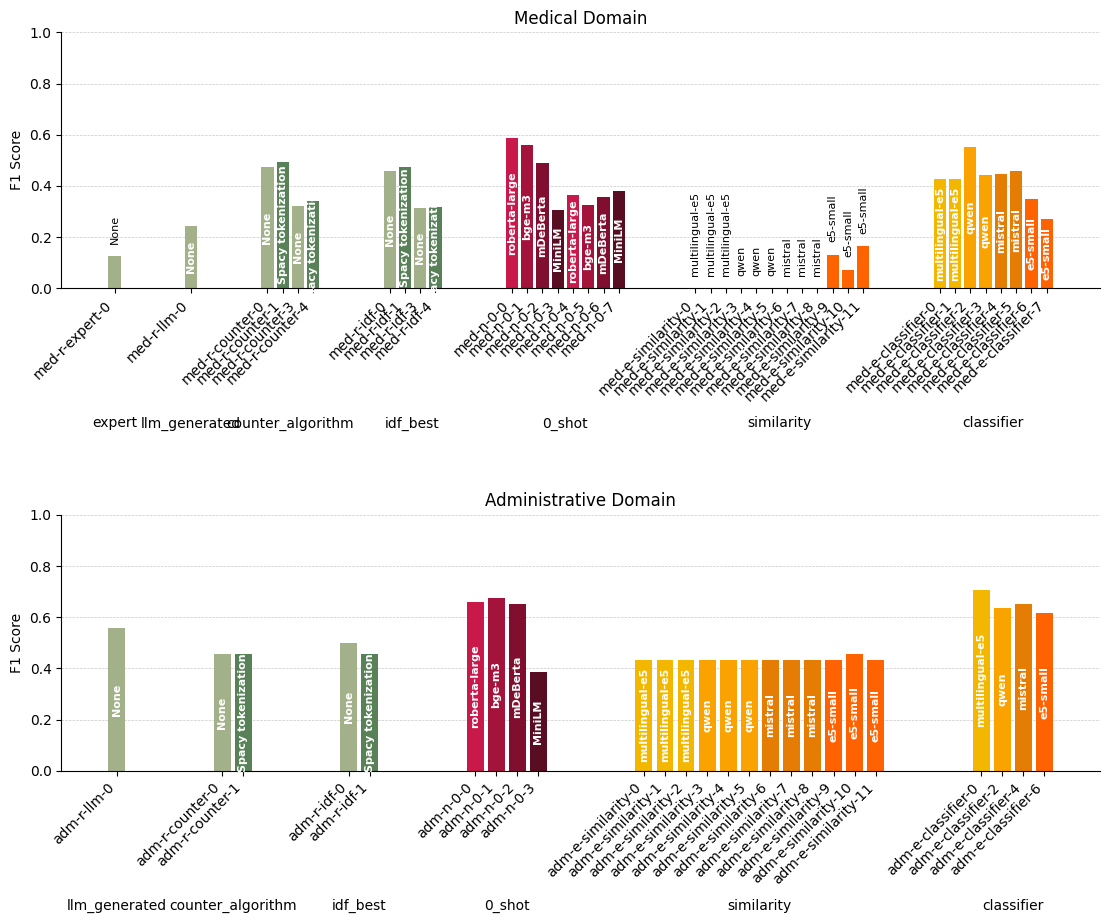

In [122]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.colors import to_hex

# Copy dataset
all_exps = exps[~((exps['Domain'].isin(['administrative', 'education'])) & (exps['second_param'] == 'svm'))]

# --- MANUAL COLOR ASSIGNMENT ---
# Define color mappings for each main_param based on Technique
rules_colors = {
    'None': '#a3b18a',  # Green shades for 'rules'
    'Spacy tokenization': '#588157',
    'Decomposition': '#3a5a40',
}

nli_colors = {
    'roberta-large': '#c9184a',  # Red shades for 'nli'
    'bge-m3': '#a4133c',
    'mDeBerta': '#800f2f',
    'MiniLM': '#590d22'
}

embedding_colors = {
    'multilingual-e5': '#F3B700',  # Yellow shades for 'embedding'
    'qwen': '#FAA300',
    'mistral': '#E57C04',
    'e5-small': '#FF6201'
}

# Combine all color mappings
color_map = {}
for param in rules_colors:
    color_map[param] = rules_colors[param]
for param in nli_colors:
    color_map[param] = nli_colors[param]
for param in embedding_colors:
    color_map[param] = embedding_colors[param]

# --- PLOTTING ---
desired_method_order = ['expert', 'llm_generated', 'counter_algorithm', 'idf_best', 'nli']
domains = all_exps['Domain'].unique()

fig, ax = plt.subplots(len(domains), 1, figsize=(14, 5 * len(domains)))

if len(domains) == 1:
    ax = [ax]

for i, domain in enumerate(domains):
    domain_exps = all_exps[all_exps['Domain'] == domain]

    present_methods = domain_exps['Method'].unique().tolist()
    methods = [m for m in desired_method_order if m in present_methods]
    methods += [m for m in present_methods if m not in methods]

    xpos, f1_scores, colors, x_labels, token_labels = [], [], [], [], []
    method_positions, method_labels = [], []

    group_spacing = 4
    current_x = 0

    for method in methods:
        group = domain_exps[domain_exps['Method'] == method]
        group_xs = []

        for _, row in group.iterrows():
            xpos.append(current_x)
            f1_scores.append(row['F1'])
            # Use color_map based on main_param
            colors.append(color_map.get(row['main_param'], 'gray'))  # Default to gray if no match
            x_labels.append(row['ID'])
            token = row['main_param']
            token_labels.append(str(token) if pd.notnull(token) else '—')
            group_xs.append(current_x)
            current_x += 1

        if group_xs:
            method_positions.append(np.mean(group_xs))
            method_labels.append(method)
            current_x += group_spacing

    # Plot bars
    for x, height, color in zip(xpos, f1_scores, colors):
        ax[i].bar(x, height, color=color)

    # Smart labels: inside or above
    threshold = 0.2
    for j, bar in enumerate(ax[i].patches):
        height = bar.get_height()
        label = token_labels[j]

        if height >= threshold:
            ax[i].text(bar.get_x() + bar.get_width()/2, height / 2, label,
                       ha='center', va='center', color='white', fontsize=8, fontweight='bold', rotation=90)
        else:
            ax[i].text(bar.get_x() + bar.get_width()/2, height + 0.05, label,
                       ha='center', va='bottom', color='black', fontsize=8, rotation=90)

    # Axis formatting
    ax[i].set_xticks(xpos)
    ax[i].set_xticklabels(x_labels, rotation=45, ha='right')
    ax[i].set_ylabel('F1 Score')
    ax[i].set_title(f'{domain.capitalize()} Domain')

    # Add horizontal gridlines
    ax[i].yaxis.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    ax[i].set_axisbelow(True)

    # Remove top and right spines
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)

    # Method group labels
    for x_pos, label in zip(method_positions, method_labels):
        ax[i].text(x_pos, -0.5, label, ha='center', va='top', fontsize=10,
                   transform=ax[i].get_xaxis_transform())
    ax[i].set_ylim(0, 1)

plt.tight_layout(rect=[0, 0.02, 0.8, 1]) 
plt.show()

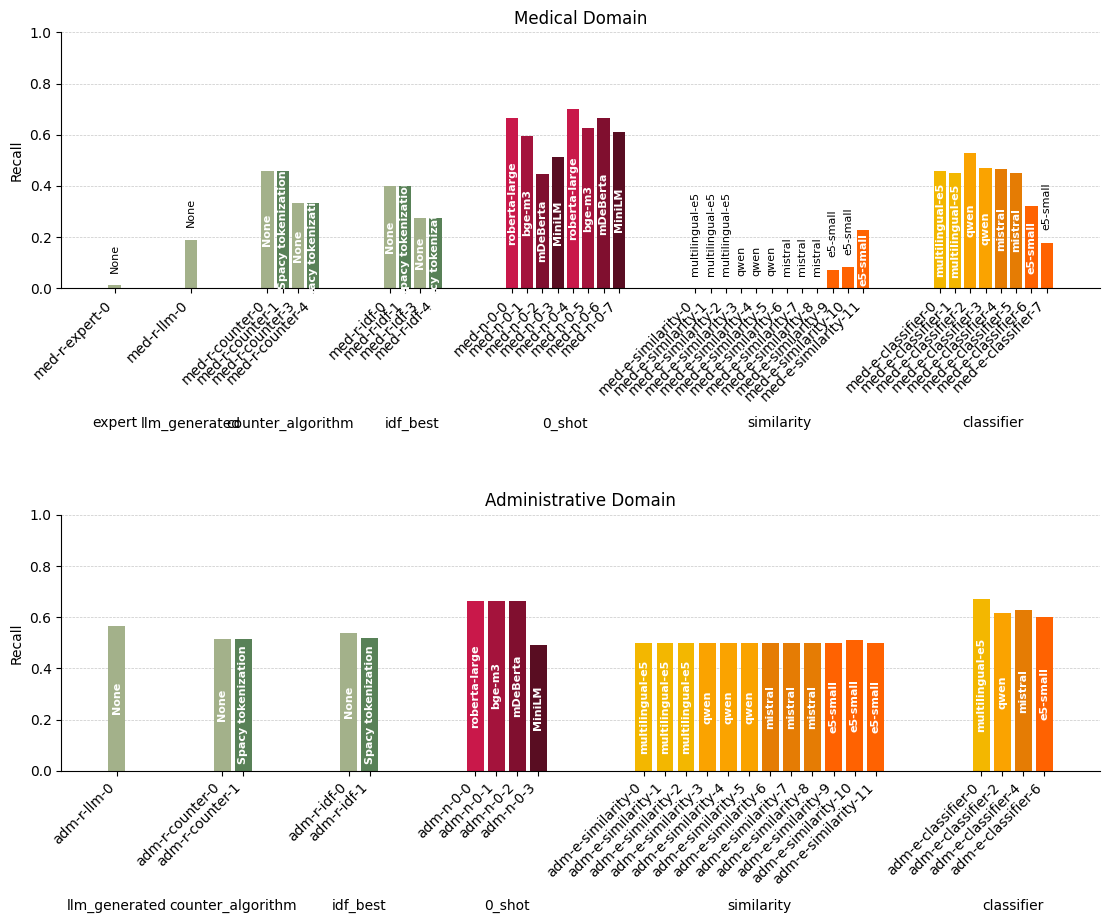

In [113]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.colors import to_hex

# Copy dataset

# --- MANUAL COLOR ASSIGNMENT ---
# Define color mappings for each main_param based on Technique
rules_colors = {
    'None': '#a3b18a',  # Green shades for 'rules'
    'Spacy tokenization': '#588157',
    'Decomposition': '#3a5a40',
}

nli_colors = {
    'roberta-large': '#c9184a',  # Red shades for 'nli'
    'bge-m3': '#a4133c',
    'mDeBerta': '#800f2f',
    'MiniLM': '#590d22'
}

embedding_colors = {
    'multilingual-e5': '#F3B700',  # Yellow shades for 'embedding'
    'qwen': '#FAA300',
    'mistral': '#E57C04',
    'e5-small': '#FF6201'
}

# Combine all color mappings
color_map = {}
for param in rules_colors:
    color_map[param] = rules_colors[param]
for param in nli_colors:
    color_map[param] = nli_colors[param]
for param in embedding_colors:
    color_map[param] = embedding_colors[param]

# --- PLOTTING ---
desired_method_order = ['expert', 'llm_generated', 'counter_algorithm', 'idf_best', 'nli']
domains = all_exps['Domain'].unique()

fig, ax = plt.subplots(len(domains), 1, figsize=(14, 5 * len(domains)))

if len(domains) == 1:
    ax = [ax]

for i, domain in enumerate(domains):
    domain_exps = all_exps[all_exps['Domain'] == domain]

    present_methods = domain_exps['Method'].unique().tolist()
    methods = [m for m in desired_method_order if m in present_methods]
    methods += [m for m in present_methods if m not in methods]

    xpos, f1_scores, colors, x_labels, token_labels = [], [], [], [], []
    method_positions, method_labels = [], []

    group_spacing = 4
    current_x = 0

    for method in methods:
        group = domain_exps[domain_exps['Method'] == method]
        group_xs = []

        for _, row in group.iterrows():
            xpos.append(current_x)
            f1_scores.append(row['Recall'])
            # Use color_map based on main_param
            colors.append(color_map.get(row['main_param'], 'gray'))  # Default to gray if no match
            x_labels.append(row['ID'])
            token = row['main_param']
            token_labels.append(str(token) if pd.notnull(token) else '—')
            group_xs.append(current_x)
            current_x += 1

        if group_xs:
            method_positions.append(np.mean(group_xs))
            method_labels.append(method)
            current_x += group_spacing

    # Plot bars
    for x, height, color in zip(xpos, f1_scores, colors):
        ax[i].bar(x, height, color=color)

    # Smart labels: inside or above
    threshold = 0.2
    for j, bar in enumerate(ax[i].patches):
        height = bar.get_height()
        label = token_labels[j]

        if height >= threshold:
            ax[i].text(bar.get_x() + bar.get_width()/2, height / 2, label,
                       ha='center', va='center', color='white', fontsize=8, fontweight='bold', rotation=90)
        else:
            ax[i].text(bar.get_x() + bar.get_width()/2, height + 0.05, label,
                       ha='center', va='bottom', color='black', fontsize=8, rotation=90)

    # Axis formatting
    ax[i].set_xticks(xpos)
    ax[i].set_xticklabels(x_labels, rotation=45, ha='right')
    ax[i].set_ylabel('Recall')
    ax[i].set_title(f'{domain.capitalize()} Domain')

    # Add horizontal gridlines
    ax[i].yaxis.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    ax[i].set_axisbelow(True)

    # Remove top and right spines
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)

    # Method group labels
    for x_pos, label in zip(method_positions, method_labels):
        ax[i].text(x_pos, -0.5, label, ha='center', va='top', fontsize=10,
                   transform=ax[i].get_xaxis_transform())
    ax[i].set_ylim(0, 1)

plt.tight_layout(rect=[0, 0.02, 0.8, 1]) 
plt.show()

# Tables

In [37]:
exps = load_experiments()
display(exps)

,ID,Domain,Technique,Method,Parameters,Accuracy,Recall,F1
0,med-r-expert-0,medical,rules,expert,"{'structure': 'nested-class', 'keywords': {'wh...",0.956268,0.109266,0.148029
1,med-r-llm-0,medical,rules,llm_generated,"{'structure': 'nested-class', 'token_num': 5, ...",0.964596,0.534446,0.372017
2,adm-r-llm-0,administrative,rules,llm_generated,"{'structure': '2-class', 'token_num': 5, 'keyw...",0.907144,0.689637,0.713588
3,edu-r-llm-0,education,rules,llm_generated,"{'structure': '3-multiclass', 'token_num': 5, ...",0.825499,0.216542,0.338022
4,med-r-counter-0,medical,rules,counter_algorithm,"{'structure': '3-class', 'preprocessing': 'Non...",0.975849,0.581476,0.437205
...,...,...,...,...,...,...,...,...
95,med-e-classifier-7,medical,embedding,classifier,"{'structure': 'nested-class', 'model': 'e5-sma...",0.979095,0.620456,0.537543
96,adm-e-classifier-6,administrative,embedding,classifier,"{'structure': '2-class', 'model': 'e5-small', ...",0.876291,0.874330,0.758679
97,adm-e-classifier-7,administrative,embedding,classifier,"{'structure': '2-class', 'model': 'e5-small', ...",0.942260,0.918194,0.862910
98,edu-e-classifier-4,education,embedding,classifier,"{'structure': '3-multiclass', 'model': 'mistra...",0.898863,0.918018,0.775537


In [38]:
exps = load_experiments()
# Expand Parameters dictionary into separate columns
exps = exps[exps['Technique'] == 'rules']
exps['Structure'] = exps['Parameters'].apply(lambda x: x.get('structure'))
exps['Preprocessing'] = exps['Parameters'].apply(lambda x: x.get('preprocessing','None'))
exps['Tokens'] = exps['Parameters'].apply(lambda x: x.get('token_num'))
exps = exps.drop('Parameters', axis=1)
# Ensure 'Tokens' is formatted with non-decimal digits
exps['Tokens'] = exps['Tokens'].apply(lambda x: int(x) if pd.notna(x) and float(x).is_integer() else 'N/A')
# Reorder columns: move 'F1' and 'Recall' to the end
columns_order = [col for col in exps.columns if col not in ['F1', 'Recall']] + ['F1', 'Recall']
exps = exps[columns_order]



latex_output = exps.to_latex(index=False)
print(latex_output)
display(exps)
# Filter experiments with 'keywords' in the 'Method' column



\begin{tabular}{llllrlllrr}
\toprule
ID & Domain & Technique & Method & Accuracy & Structure & Preprocessing & Tokens & F1 & Recall \\
\midrule
med-r-expert-0 & medical & rules & expert & 0.956268 & nested-class & None & N/A & 0.148029 & 0.109266 \\
med-r-llm-0 & medical & rules & llm_generated & 0.964596 & nested-class & None & 5 & 0.372017 & 0.534446 \\
adm-r-llm-0 & administrative & rules & llm_generated & 0.907144 & 2-class & None & 5 & 0.713588 & 0.689637 \\
edu-r-llm-0 & education & rules & llm_generated & 0.825499 & 3-multiclass & None & 5 & 0.338022 & 0.216542 \\
med-r-counter-0 & medical & rules & counter_algorithm & 0.975849 & 3-class & None & 7 & 0.437205 & 0.581476 \\
med-r-counter-1 & medical & rules & counter_algorithm & 0.977055 & 3-class & Spacy tokenization & 6 & 0.441113 & 0.567093 \\
med-r-counter-2 & medical & rules & counter_algorithm & 0.982720 & 3-class & Decomposition & 3 & 0.443624 & 0.427147 \\
med-r-counter-3 & medical & rules & counter_algorithm & 0.982522 &

,ID,Domain,Technique,Method,Accuracy,Structure,Preprocessing,Tokens,F1,Recall
0,med-r-expert-0,medical,rules,expert,0.956268,nested-class,None,N/A,0.148029,0.109266
1,med-r-llm-0,medical,rules,llm_generated,0.964596,nested-class,None,5,0.372017,0.534446
2,adm-r-llm-0,administrative,rules,llm_generated,0.907144,2-class,None,5,0.713588,0.689637
3,edu-r-llm-0,education,rules,llm_generated,0.825499,3-multiclass,None,5,0.338022,0.216542
4,med-r-counter-0,medical,rules,counter_algorithm,0.975849,3-class,None,7,0.437205,0.581476
5,med-r-counter-1,medical,rules,counter_algorithm,0.977055,3-class,Spacy tokenization,6,0.441113,0.567093
6,med-r-counter-2,medical,rules,counter_algorithm,0.982720,3-class,Decomposition,3,0.443624,0.427147
7,med-r-counter-3,medical,rules,counter_algorithm,0.982522,nested-class,None,7,0.472809,0.554880
8,med-r-counter-4,medical,rules,counter_algorithm,0.984144,nested-class,Spacy tokenization,6,0.486180,0.545816
9,med-r-counter-5,medical,rules,counter_algorithm,0.980594,nested-class,Decomposition,7,0.481839,0.554304


In [39]:
from collections import defaultdict
import pandas as pd

exps = load_experiments()
exps = exps[exps['Technique'] == 'rules']

# Extract 'keywords' dict (organized by class) from parameters
exps['Class_Country_Keywords'] = exps['Parameters'].apply(lambda x: x.get('keywords') if isinstance(x, dict) else None)

# Collect all unique classes
class_keys = set()
exps['Class_Country_Keywords'].dropna().apply(lambda x: class_keys.update(x.keys()))

# Create a table per class
class_tables = {}

for class_key in class_keys:
    # For each class, extract the keywords per country
    def extract_country_keywords(class_dict):
        if isinstance(class_dict, dict) and class_key in class_dict:
            return class_dict[class_key]
        return {}

    # New column with the country-keyword dict for this class
    exps[f'{class_key}_CountryKeywords'] = exps['Class_Country_Keywords'].apply(extract_country_keywords)

    # Get all countries used in this class
    country_keys = set()
    exps[f'{class_key}_CountryKeywords'].dropna().apply(lambda x: country_keys.update(x.keys()))

    # Build a dataframe per class
    class_df = exps.copy()
    for country in country_keys:
        class_df[country] = class_df[f'{class_key}_CountryKeywords'].apply(
            lambda x: x.get(country) if isinstance(x, dict) else None
        )

    # Optional: drop the intermediate column
    class_df = class_df.drop(columns=[f'{class_key}_CountryKeywords'])

    # Store the table
    class_tables[class_key] = class_df
from orgpackage.config import COUNTRY_DICT

for class_name, df in class_tables.items():
    print(f"\n=== Class: {class_name} ===\n")

    # Keep only country keyword columns present in COUNTRY_DICT
    country_cols = [col for col in df.columns if col in COUNTRY_DICT]

    if not country_cols:
        continue  # Skip if no matching country columns

    # Subset to country keyword columns and the experiment name
    keyword_df = df[['ID'] + country_cols].copy()

    # Filter out rows where all country values are None
    keyword_df = keyword_df.dropna(subset=country_cols, how='all')

    # Convert lists to strings (comma-separated), empty string for empty lists or None
    for col in country_cols:
        keyword_df[col] = keyword_df[col].apply(
            lambda x: ", ".join(x) if isinstance(x, list) and x else ""
        )

    # Rename columns using COUNTRY_DICT
    rename_map = {code: COUNTRY_DICT[code]['country'] for code in country_cols if 'country' in COUNTRY_DICT[code]}
    keyword_df.rename(columns=rename_map, inplace=True)

    # Set 'Experiment' as index
    keyword_df.set_index('ID', inplace=True)

    # Display the final cleaned table
    display(keyword_df)


=== Class: whitelist_local_government ===



,Lithuania,Sweden,Slovenia,Czech Republic,Greece,Germany,Latvia,Slovakia,Spain,Hungary,...,Netherlands,France,Portugal,Bulgaria,Estonia,Croatia,Denmark,Italy,Luxembourg,Finland
ID,,,,,,,,,,,,,,,,,,,,,
adm-r-llm-0,"Miestas, Savivaldas, Lietuvos, Valstybinis, Karo","Kommun, Falkenberg, Municipality, Local Govern...","Opčin, Podimje, Slovenija, Goriško, Primorje","Obvod, Praga, Česká, Říčany, Moravia","Demos, Komisaría, Community Council, Municipal...","Gemeinde, Stadtverband, Kommune, Verwaltungsei...","Parks, Valsts, Společnost, Local Authority, La...","Obec, Slovenska, Obci, Primorje, Koroška","Ayuntamiento, Diputación, Junta de Gobierno, M...","Város, Hungarika, Kormányzati, Megye, Környezet",...,"Gemeente, Municipality, Local Government, Wijk...","Mairie, Commune, Conseil Municipal, EPCI, Région","Município, Câmara, Conselho, IBD, Junta","Община, София, България, Пловдив, Варна","Vald, Municipalita, Estnische, Local Governmen...","Općina, Zagreb, Dalmacija, Split, Osijek","Kommune, Dania, København, Aarhus, Odense","Comune, Amministrazione Locale, Municipio, Cit...","Commune, Luxembourg, Grand-Duché, Monschau, Es...","Kunta, Kaupunki, Yhteisö, Municipality, Vald"
adm-r-counter-0,"taryba, m, savivaldybės","stadsdelsområde, region, biskopsgården","mestni, mestne, občine","radnice, úřad, stará",,"verwaltungsgemeinschaft, landkreis, amt","pārvalde, pagasta, pašvaldības","radnica, stará, obecný","ayuntamiento, ajuntament, arriba","városháza, tankerületi, központ",...,"gemeenteraad, van, hagestein","aubin, mairie, déléguée","municipal, câmara, assembleia",,"linnavolikogu, viljandi, pärnu","komunalna, palača, puli","rådhus, gamle, borgerrepræsentationen","parco, naturale, urbano","conseil, communal, steinsel","kunnanvaltuusto, kaupunginvaltuusto, maalaiskunta"
adm-r-counter-1,"taryba, m, savivaldybė","stadsdelsområde, region, biskopsgården","mesten, občina, sž","radnice, úřad, stará",,"verwaltungsgemeinschaft, landkreis, amt","pārvalde, pagasta, pašvaldības","radnica, stará, obecný","ayuntamiento, ajuntament, montejo","városháza, tankerületi, központ",...,"gemeenteraad, hagestein, ambt","aubin, les, mairie","municipal, câmara, assembleia",,"linnavolikogu, viljandi, pärnu","komunalan, palača, podbrežje","rådhus, borgerrepræsentation, gammel","parco, naturale, urbano","conseil, communal, steinsel","kunnanvaltuusto, kaupunginvaltuusto, maalaiskunta"
adm-r-counter-2,"taryba, m, savivaldybės","stadsdel, område, region","mestni, mestne, občine","radnice, úřad, stará",,"verwaltungsgemeinschaft, landkreis, amt","pārvalde, pagasta, pašvaldības","radnica, stará, obecný","ayuntamiento, ajuntament, arriba","városháza, tankerületi, központ",...,"gemeenteraad, van, hagestein","aubin, ign, mon","municipal, câmara, assembleia",,"linnavolikogu, viljandi, pärnu","komunalna, palača, puli","rådhus, gamle, 2021","parco, naturale, urbano","conseil, communal, ein","kunnanvaltuusto, kaupunginvaltuusto, järvi"
adm-r-idf-0,"rajono, savivaldybės, taryba","biskopsgården, region, stadsdelsområde","mestne, mestni, občine","radnice, stará, úřad",,"amt, landkreis, verwaltungsgemeinschaft","pagasta, pašvaldības, pārvalde","obecný, radnica, stará","ajuntament, ayuntamiento, de","központ, tankerületi, városháza",...,"gemeenteraad, hagestein, van","centre, commune, sociale","câmara, municipal, paredes",,"linnavolikogu, pärnu, viljandi","podbrežje, zagrebačke, četvrti","gamle, københavns, rådhus","naturale, parco, regionale","communal, conseil, steinsel","kaupunginvaltuusto, kunnanvaltuusto, maalaiskunta"
adm-r-idf-1,"rajonas, savivaldybė, taryba","biskopsgården, region, stadsdelsområde","mesten, občina, svet","radnice, stará, úřad",,"amt, landkreis, verwaltungsgemeinschaft","pagasta, pašvaldības, pārvalde","obecný, radnica, stará","ajuntament, ayuntamiento, ceip","központ, tankerületi, városháza",...,"basisschool, gemeenteraad, hagestein","centre, commune, social","câmara, municipal, paredes",,"linnavolikogu, pärnu, viljandi","komunalan, palača, podbrežje","borgerrep


=== Class: whitelist_primary_school ===



,Lithuania,Sweden,Slovenia,Czech Republic,Greece,Germany,Latvia,Slovakia,Spain,Hungary,...,Netherlands,France,Portugal,Bulgaria,Estonia,Croatia,Denmark,Italy,Luxembourg,Finland
ID,,,,,,,,,,,,,,,,,,,,,
edu-r-llm-0,"Pradiniškiai, Mokslas, Basiukai, Tarptautinis ...","Förskola, Grundskola, Barnskola, Förskoleklass...","Osnovne Škole, Prva Leta, Diploma, Učitelji, E...","Primární Škola, První Třída, Absolventi, Učite...","Δημοτικό Σχολείο, Πρόσχολος, Αρχική Σχολή, Γρα...","Volksschule, Grundschule, Unterstufe, Lehrstra...","Bauskolas, Pīkodis Skola, Grundskole, Mācību G...","Primární Škola, První Klasifikace, Diplom, Uči...","Escuela Primaria, Primaria, Grades 1-2, Educac...","Alapítványi Iskolák, Osztály, Kisdiploma, Egys...",...,"Primair College, Basisschool, Beginnende Schoo...","École Primaire, CP, Cours Primaire, Maternelle...","Escola Primária, Primeiro Ano, Ensino Primário...","Народни Училища, Първа Класа, Сертификат, Учит...","Keskkool, Algupera, Noortepool, Haridus, Sool","Osnovne Škole, Prva Godina, Diplome, Zaposleni...","Folkeskoler, Bogskole, Klasser, Studentenes, L...","Scuola Primaria, Primaria, Grades 1-5, Educazi...","Écoles Primaires, Première Année, Diplôme, Ens...","Koulunopisto, Peruskaupunki, Vesikko-Astu, Alk..."
edu-r-counter-0,"pradinė, internatinė, rudiškių, girininkų, karvio","skola, parkskolan, skolan, kyrkskolan, central...","osnovna, šola, ivana, pri, prežihovega","škola, základní, a, mateřská, umělecká","σχολείο, 2ο, καλλιθέας, οθωνών, φουρφουρά","grundschule, volksschule, hauptschule, grimmel...","pamatskola, allažu, blomes, bērzaunes, aleksandra","základná, školská, fiľakovo, zš, rákócziho","escola, ceip, cervantes, march, ausiàs","iskola, általános, gimnázium, katolikus, jános",...,"basisschool, de, christelijke, openbare, regen...","ecole, elementaire, primaire, élémentaire, spe...","primária, escola, cantina, escolar, adães","основно, оу, училище, тодор, каблешков","nõuni, algkool, laenu, mereturismi, assotsiats...","osnovna, davorina, trstenjaka, glumačka, družina","skole, efterskole, skolen, trekløverskolen, ve...","primaria, elementare, elem, plesso, cap",,"koulu, kirkonkylän, kansakoulu, keskuskoulu, ala"
edu-r-counter-1,"pradinis, internatinis, rudiškiai, girininkų, ...","skola, parkskola, kyrkskolan, centralskolan, s...","osnoven, šola, ivan, prežihovega, voranca, sve...","škola, základní, a, mateřská, umělecká, masary...","σχολείο, δημοτικός, 2ος, καλλιθέας, οθωνό, φου...","grundschule, volksschule, hauptschule, katholi...","pamatskola, allažu, blomes, bērzaunes, aleksan...","základná, školská, fiľakovo, zš, rákócziho, ii...","escola, ceip, cervantes, march, ausiàs, zer, p...","iskola, általános, gimnázium, katolikus, jános...",...,"basisschool, christelijk, openbare, regenboog,...","ecole, elementair, primaire, élémentaire, spec...","primária, escola, cantina, escolar, adães, ber...","основно, оу, училище, тодор, каблешков, 75, 6,...","nõuni, algkool, laenu, mereturismi, assotsiats...","osnovan, davorina, trstenjak, glumački, družin...","skole, efterskole, trekløverskol, vestre, kirs...","primario, primaria, elementare, elem, plesso, ...",,"koulu, kirkonkylä, kansakoulu, keskuskoulu, as..."
edu-r-counter-2,"pradinė, ni, internatinė, rudiškių, girininkų","skola, park, kola, kyrkskolan, gas","osnovna, šola, ivana, pri, prežihovega","škola, základní, a, mateřská, umělecká","σχολείο, 2ο, καλλιθέας, οθωνών, φουρφουρά","grundschule, grimm, volksschule, hauptschule, weg","pamatskola, allažu, blomes, bērzaunes, aleksandra","základná, školská, fiľakovo, zš, rákócziho","cola, ceip, es, tes, van","iskola, általános, gimnázium, katolikus, jános",...,"basisschool, de, school, christelijke, openbare","ele, primaire, mentir, élémentaire, eco","primária, escola, cantina, escolar, adães","основно, оу, училище, тодор, каблешков","nõuni, algkool, laenu, mereturismi, assotsiats...","osnovna, davorina, trstenjaka, glumačka, družina","skole, skolen, efterskole, trekløver, by","primaria, elementare, elem, ple


=== Class: whitelist_university_hospital ===



,Lithuania,Sweden,Slovenia,Czech Republic,Greece,Germany,Latvia,Slovakia,Spain,Hungary,...,Netherlands,France,Portugal,Bulgaria,Estonia,Croatia,Denmark,Italy,Luxembourg,Finland
ID,,,,,,,,,,,,,,,,,,,,,
med-r-expert-0,,,,,,,,,,,...,,"Universitaire, CHU, Institut, GHU, Faculté, Re...",,,,,,"Policlinico, Universitario, Universitaria",,
med-r-llm-0,"Universiteto, Klinik, Medicinos, Diagnostikos,...","Universitetssjukhuset, Akademiska, Sjukhus, In...","Univerza, Klinika, Medicinski, Diagnostika, In...","University, Klinik, Medicínský, Diagnostika, I...","Γενική Νοσοκομείο, Πανελληνική Ιατρική Σχολή, ...","Universitätsklinik, Klinikum, Institut, Zentru...","Universitātes slimikums, Rīkodiski slimīkums, ...","Vyskej školy, Klinik, Medicínska, Diagnóza, In...","Hospital Universitario, Universidad, Clínico, ...","Egyetemi, Klinik, Orvosi, Diagnosztika, Intezmeny",...,"Universitair Ziekenhuis, Ziekenhuisgroep, Medi...","Hôpital Universitaire, Service de Santé, Résea...","Hospital Universitário, Serviço, Nacional, Esc...","Университет, Клиника, Медicina, Диагностика, И...","Tervise keskus, Kliinikum, Medicum, Õppuskesku...","Sveučilište, Klinika, Medicínska, Diagnosztika...","Universitet, Klinik, Medicinsk, Diagnostik, In...","Ospedale Universitario, Dottorato, Unità, Medi...","Université, Klinik, Medicinal, Diagnose, Institut","Yliopistollinen Sairaala, Klinikka, Medicum, K..."
med-r-counter-0,,"universitetssjukhuset, huddinge, karolinska, n...",,,,"carus, uksh, isar, gustav, hautklinik, inschri...","klīniskā, universitātes, bērnu, mobnx, 60, asp...",,"plana, elda, clínico, blesa, rio, hortega, línea",,...,"academisch, leids, peter, appel, afrikaansche,...","mustapha, pacha, ap, hp, sorbonne, lingenheld,...",,,"tartu, ülikooli, kliinikum, lastehaigla, kala,...",,"universitetshospital, penny, lane, medicinsk, ...","mezzenile, silvi, naturasì, polifunzionale, ro...",,
med-r-counter-1,,"universitetssjukhuset, huddinge, karolinska, n...",,,,"carus, uksh, rechts, isar, gustav, hautklinik","klīniskā, universitātes, bērnu, mobnx, 60, asp...",,"plana, elda, clínico, blesa, rio, hortega",,...,"peter, appel, afrikaansch, sportverband, roose...","mustapha, pacha, ap, hp, sorbonne, lingenheld",,,"tartu, ülikooli, kliinikum, lastehaigla, kala,...",,"universitetshospital, penny, lane, medicinsk, ...","mezzenile, silvi, naturasì, polifunzionale, ro...",,
med-r-counter-2,,"universitetssjukhuset, karolinska, nordmalings...",,,,"uksh, isar, gustav","klīniskā, universitātes, bērnu",,"plana, elda, clínico",,...,"academisch, leids, peter","mustapha, pacha, sorbonne",,,"tartu, ülikooli, kliinikum",,"universitetshospital, lane, uddannelse","mezzenile, silvi, natura",,
med-r-counter-3,,"huddinge, karolinska, universitetssjukhuset, s...",,,,"universitätsklinikum, holstein, saarlandes, je...","bērnu, klīniskā, universitātes, biķernieki, do...",,"macarena, cristina, victoria, plana, elda, req...",,...,"academisch, maastricht, groningen, leids, pann...","sorbonne, université, mustapha, pacha, régiona...",,,"tartu, ülikooli, kliinikum, lastehaigla, vilja...",,"universitetshospital, aarhus, odense, aalborg,...","umberto, i, bari, ca, foncello, zona, potenza",,
med-r-counter-4,,"huddinge, karolinska, universitetssjukhuset, s...",,,,"universitätsklinikum, holstein, jena, carl, gu...","bērnu, klīniskā, universitātes, biķernieki, do...",,"macarena, cristina, victoria, plana, elda, req...",,...,"academisch, maastricht, groningen, leids, pann...","sorbonne, université, mustapha, pacha, régiona...",,,"tartu, ülikooli, kliinikum, lastehaigla, vilja...",,"universitetshospital, aarhus, odense, aalborg,...","umberto, i, bari, ca, foncello, zona",,
med-r-counter-5,,"huddinge, karolinska, universitetssjukhuset, s...",,,,"universitätsklinikum, holstein, jena, carl, gu...","bērnu, klīniskā, universitātes, biķernieki, do...",,"macar, cristina, victoria, plana, elda, requen...",,...,"academisch, tricht, groningen, leids, panninge...","sorbonne, université, mustapha, pacha, régiona...


=== Class: whitelist_secondary_school ===



,Lithuania,Sweden,Slovenia,Czech Republic,Greece,Germany,Latvia,Slovakia,Spain,Hungary,...,Netherlands,France,Portugal,Bulgaria,Estonia,Croatia,Denmark,Italy,Luxembourg,Finland
ID,,,,,,,,,,,,,,,,,,,,,
edu-r-llm-0,"Gimnazija, Mokykla, Pergalė, Licejums, Auksova...","Gymnasium Sekundar, Realkaka, Vuxenutbildnings...","Srednja Šola, Gymnasium, Srednja Škola, Osnovn...","Střední Škola, Gymnázium, Srednja Škola, Vyšší...","Geniko Lykeio, Dekaproto Lykeio, Lykeio tis Ky...","Gymnasium, Realschule, Hauptschule, Schule Sek...","Gymnāzija, Diplomantili Gymnāzija, Vidusskola,...","Stredná Škola, Gymnázium, Střední škola, Vyšší...","Instituto, Escuela, Colegio, Liceo, Secundaria","Középiskola, Gymnázium, Střední škola, Ímenyál...",...,"Vogeschool, MULO, VMBO School, Kies School, Ba...","Collège, Lycée, École Secondaire, Section de S...","Escola Secundária, Ensino Secundário, Institut...","Средни училища, Secondary School, Драгоучение,...","Gümnaasium, Diplomaire Gümnaasium, Võrdlusgümn...","Srednjak, Društvo Srednjaka, Srednjaška Zajedn...","Gymnasium, Folkeskole, Højskole, Aarhus Univer...","Liceo Scientifico, Istituto d'Arte, Scuola Sec...","Collège Secondaire, Lycée, École Secondaire, G...","Yläasteenopisto, Keskiasteenopisto, Asteenopis..."
edu-r-counter-0,"gymnasium, gimnazija, progimnazija, school, vi...","folkhögskola, gymnasium, gymnasiet, gymnasiesk...","srednja, gimnazija, ekonomska, šolski, univerza","gymnázium, střední, odborná, akademie, obchodní","γυμνάσιο, λύκειο, εσπερινό, αργοστολίου, πρότυπο","gymnasium, freiherr, vom, stein, albert","vidusskola, ģimnāzija, valsts, jelgavas, kuldīgas","gymnázium, škola, stredná, spojená, priemyselná","institut, ies, valor, enric, secundaria",,...,"gymnasium, scholengemeenschap, csg, maartensco...","lycée, collège, séminaire, monnet, voltaire","liceu, industrial, comercial, nova, camilo","гимназия, средно, професионална, су, соу",,"gimnazija, klasična, prva, u, ruđera","skole, efterskole, gymnasium, skolen, trekløve...","liceo, scientifico, vinci, leonardo, bosco","lycée, école, maacher, privée, sainte","school, lukio, opisto, yhteiskoulu, kansalaiso..."
edu-r-counter-1,"gimnazija, progimnazija, school, vidurinis, gy...","gymnasium, folkhögskola, gymnasiet, gymnasiesk...","gimnazija, ekonomski, šolski, univerza, življe...","gymnázium, střední, odborná, akademie, obchodn...","γυμνάσιο, λύκειο, εσπερινός, αργοστολίου, πρότ...","gymnasium, vom, freiherr, stein, albert, gesam...","vidusskola, ģimnāzija, valsts, jelgavas, kuldī...","gymnázium, škola, stredná, spojená, priemyseln...","institut, ies, valor, enric, secundaria, milà,...",,...,"gymnasium, scholengemeenschap, csg, maartensco...","lycée, collège, séminaire, monnet, voltaire, v...","liceu, industrial, comercial, camilo, filipa, ...","гимназия, средно, професионална, су, соу, по, ...",,"gimnazija, klasičan, prvi, ruđera, bošković, v...","skole, efterskole, gymnasium, trekløverskol, h...","liceo, scientifico, vinci, leonardo, bosco, cl...","lycée, école, maacher, privée, sainte, anne, e...","school, lukio, opisto, yhteiskoulu, kansalaiso..."
edu-r-counter-2,"gimnazija, gymnasium, pr, school, vidurinė","gymnasium, folkhögskola, gymnasieskola, blanka...","srednja, gimnazija, ekonomska, šolski, univerza","gymnázium, střední, odborná, akademie, obchodní","γυμνάσιο, λύκειο, εσπερινό, αργοστολίου, πρότυπο","gymnasium, freiherr, vom, albert, gesamtschule","vidusskola, ģimnāzija, valsts, jelgavas, kuldīgas","gymnázium, škola, stredná, spojená, priemyselná","institut, ies, valor, enric, secundaria",,...,"gymnasium, scholengemeenschap, csg, ae, illustre","lycée, collège, séminaire, monnet, voltaire","liceu, industrial, comercial, nova, camilo","гимназия, средно, професионална, су, соу",,"gimnazija, klasična, prva, u, ruđera","skole, skolen, efterskole, gymnasium, by","liceo, scientifico, vinci, nardo, bosco","lycée, école, maacher, privé, sainte","school, lukio, opisto, yhteiskoulu, kansalaiso..."
edu-r-idf-0,"gimnazija, gymnasium, jono, progimn


=== Class: whitelist_hospital ===



,Lithuania,Sweden,Slovenia,Czech Republic,Greece,Germany,Latvia,Slovakia,Spain,Hungary,...,Netherlands,France,Portugal,Bulgaria,Estonia,Croatia,Denmark,Italy,Luxembourg,Finland
ID,,,,,,,,,,,,,,,,,,,,,
med-r-expert-0,,,,,,,,,,,...,,"Hôpital, Hospitalier, CH, CHU, Médical, GHT, G...",,,,,,"Ospedale, Presidio Sanitario, Nosocomio, Azien...",,
med-r-llm-0,"Hospital, Lietuvos, Klinikas, Specializuotis, ...","Sjukhus, Medicinhus, Klinisk Centrum, Sanatori...","Klinika, Specialist, Ljubljanski, Medic, Mestni","Hospital, Specialist, Prague, Střední, Městská","Hospital, Κλινική, Ιατρός, ΑκτIVEΝη, Υπηλόσκοπο","Krankenhaus, Medizinische Einrichtung, Gesundh...","Slimsniškana, Klinik, Medicāliski Centri, Psih...","Hospital, Specialist, Bratislavský, Košický, M...","Hospital, Clínica, Centro, Sanatorio, Instituto","Kórház, Specialista, Országos, Budapesti, Műve...",...,"Ziekenhuis, Medisch Centrum, Kliniek, Sanatori...","Hospital, Hôpital, Services Hospitaliers, Unit...","Hospital, Maternidade, Centro Hospitalar, Unid...","Hospital, Specialist, Sofия, Medic, Местен","Kliinik, Medicinali, Psihiatriline Klinika, Pe...","Hospital, Specialist, Dalmatinski, Zdravstveni...","Hospital, Specialist, København, Sjukhus, Muni...","Ospedale, Clinica, Maternità, Centro, Poli","Hospital, Spital, Specialist, Medic, Luxembourg","Sairaal, Klinikka, Medicinali, Sairaushus, Yli..."
med-r-counter-0,"ligoninė, respublikinė, universitetinė, tuberk...","sjukhus, universitetssjukhus, hospital, skånes...","bolnišnica, splošna, klinika, psihiatrična, vo...","nemocnice, psychiatrická, klinika, léčebna, št...","νοσοκομείο, γενικό, κέντρο, ψυχιατρικό, θεραπε...","krankenhaus, ehemaliges, klinikum, spital, hos...","slimnīca, reģionālā, pilsētas, rehabilitācijas...","hospital, in, nemocnica, prešov, šaca, kúpeľná...","hospital, clínica, dios, día, universitari, sa...","kórház, rendelőintézet, albert, vaszary, kolos...",...,"ziekenhuis, medisch, centrum, polikliniek, uni...","hôpital, hospitalier, dieu, hospice, local, cl...","hospital, santa, cuf, misericórdia, igreja, sã...","болница, мбал, вита, аджибадем, клиник, токуда...","haigla, lastehaigla, tartu, ülikooli, kliiniku...","bolnica, kbc, hospital, klinički, bolnički, dr...","hospital, universitetshospital, sygehus, regio...","ospedale, policlinico, asst, hospital, lazzare...","hospitalier, centre, neuro, psychiatrique, émi...","sairaala, keskussairaala, sydänsairaala, entin..."
med-r-counter-1,"ligoninis, respublikinė, universitetinė, tuber...","sjukhus, universitetssjukhus, hospital, centra...","bolnišnica, splošen, klinika, psihiatričen, vo...","nemocnice, psychiatrická, klinika, léčebna, št...","νοσοκομείο, γενικό, κέντρο, ψυχιατρικό, θεραπε...","krankenhaus, klinikum, klinik, spital, hospita...","slimnīca, reģionālā, pilsētas, rehabilitācijas...","hospital, in, nemocnica, prešov, šaca, kúpeľná","hospital, clínica, dios, universitari, sanator...","kórház, rendelőintézet, albert, vaszary, kolos...",...,"ziekenhuis, medisch, centrum, polikliniek, uni...","hôpital, hospitalier, dieu, hospice, clinique,...","hospital, santa, cuf, misericórdia, igreja, re...","болница, мбал, вита, аджибадем, клиник, токуда","haigla, lastehaigla, tartu, ülikooli, kliiniku...","bolnica, kbc, hospital, klinički, bolnički, dr","hospital, universitetshospital, sygehus, regio...","ospedale, policlinico, asst, hospital, lazzare...","hospitalier, centre, neuro, psychiatriqu, émil...","sairaala, keskussairaala, sydänsairaala, tyks,..."
med-r-counter-2,"ligoninė, respublikinė, universitetinė","sjukhus, universitetssjukhus, hospital","bolnišnica, splošna, klinika","nemocnice, psychiatrická, klinika","νοσοκομείο, γενικό, κέντρο","krankenhaus, klinik, klinikum","slimnīca, reģionālā, pilsētas","hospital, in, nemocnica","hospital, clínica, dios","kórház, rendelőintézet, albert",...,"ziekenhuis, medisch, polikliniek","hôpital, hospitalier, hospice","hospital, santa, cuf","болница, мбал, вита","haigla, lastehaigla, tartu","bolnica, kbc, hospital","ho

In [40]:
from IPython.display import display, Latex
keyword_tables = {}

for class_name, df in class_tables.items():

    country_cols = [col for col in df.columns if col in COUNTRY_DICT]

    if not country_cols:
        continue

    keyword_df = df[['ID'] + country_cols].copy()
    keyword_df = keyword_df.dropna(subset=country_cols, how='all')

    for col in country_cols:
        keyword_df[col] = keyword_df[col].apply(lambda x: ", ".join(x) if isinstance(x, list) and x else "")

    rename_map = {code: COUNTRY_DICT[code]['country'] for code in country_cols if 'country' in COUNTRY_DICT[code]}
    keyword_df.rename(columns=rename_map, inplace=True)

    keyword_df.set_index('ID', inplace=True)

    keyword_tables[class_name] = keyword_df  # ✅ Store cleaned version
cols = ['Germany', 'France']

for class_name, df in keyword_tables.items():
    print(f"\n=== LaTeX for Class: {class_name} ===\n")

    available_cols = [col for col in cols if col in df.columns]

    if not available_cols:
        print("No matching columns in this class.")
        continue

    filtered_df = df[available_cols].copy()

    latex_str = filtered_df.to_latex(
    )

    print(latex_str)


=== LaTeX for Class: whitelist_local_government ===

\begin{tabular}{lll}
\toprule
 & Germany & France \\
ID &  &  \\
\midrule
adm-r-llm-0 & Gemeinde, Stadtverband, Kommune, Verwaltungseinheit, Raad & Mairie, Commune, Conseil Municipal, EPCI, Région \\
adm-r-counter-0 & verwaltungsgemeinschaft, landkreis, amt & aubin, mairie, déléguée \\
adm-r-counter-1 & verwaltungsgemeinschaft, landkreis, amt & aubin, les, mairie \\
adm-r-counter-2 & verwaltungsgemeinschaft, landkreis, amt & aubin, ign, mon \\
adm-r-idf-0 & amt, landkreis, verwaltungsgemeinschaft & centre, commune, sociale \\
adm-r-idf-1 & amt, landkreis, verwaltungsgemeinschaft & centre, commune, social \\
adm-r-idf-2 & amt, landkreis, verwaltungsgemeinschaft & centre, commune, social \\
\bottomrule
\end{tabular}


=== LaTeX for Class: whitelist_primary_school ===

\begin{tabular}{lll}
\toprule
 & Germany & France \\
ID &  &  \\
\midrule
edu-r-llm-0 & Volksschule, Grundschule, Unterstufe, Lehrstrafene, Basiskenntnisse & École Prima

# NLI

In [41]:
exps = load_experiments()
# Expand Parameters dictionary into separate columns
exps = exps[exps['Technique'] == 'nli']
exps['Model'] = exps['Parameters'].apply(lambda x: x.get('model'))

exps['Structure'] = exps['Parameters'].apply(lambda x: x.get('structure'))
exps = exps.drop('Parameters', axis=1)
columns_order = [col for col in exps.columns if col not in ['F1', 'Recall']] + ['F1', 'Recall']
exps = exps[columns_order]



latex_output = exps.to_latex(index=False)
print(latex_output)
# Filter experiments with 'keywords' in the 'Method' column



\begin{tabular}{llllrllrr}
\toprule
ID & Domain & Technique & Method & Accuracy & Model & Structure & F1 & Recall \\
\midrule
med-n-0-0 & medical & nli & 0_shot & 0.948466 & roberta-large & 3-class & 0.405432 & 0.747089 \\
med-n-0-1 & medical & nli & 0_shot & 0.963248 & bge-m3 & 3-class & 0.413264 & 0.736307 \\
med-n-0-2 & medical & nli & 0_shot & 0.980167 & mDeBerta & 3-class & 0.476352 & 0.593545 \\
med-n-0-3 & medical & nli & 0_shot & 0.522452 & MiniLM & 3-class & 0.123156 & 0.625190 \\
med-n-0-4 & medical & nli & 0_shot & 0.253989 & roberta-large & nested-class & 0.054539 & 0.809255 \\
med-n-0-5 & medical & nli & 0_shot & 0.045716 & bge-m3 & nested-class & 0.041871 & 0.565684 \\
med-n-0-6 & medical & nli & 0_shot & 0.149934 & mDeBerta & nested-class & 0.053806 & 0.777962 \\
med-n-0-7 & medical & nli & 0_shot & 0.698137 & MiniLM & nested-class & 0.142762 & 0.739025 \\
adm-n-0-0 & administrative & nli & 0_shot & 0.896647 & roberta-large & 2-class & 0.767278 & 0.826847 \\
adm-n-0-1 & 

In [62]:
exps = load_experiments()
# Expand Parameters dictionary into separate columns
exps = exps[(exps['Technique'] == 'embedding') & (exps['Method'] == 'classifier')]

print( exps.iloc[1]['Parameters'].keys())
exps['Model'] = exps['Parameters'].apply(lambda x: x.get('model'))
exps['Classifier'] = exps['Parameters'].apply(lambda x: x.get('classifier'))
exps['Structure'] = exps['Parameters'].apply(lambda x: x.get('structure'))
exps['C'] = exps['Parameters'].apply(lambda x: x.get('C'))
exps['solver'] = exps['Parameters'].apply(lambda x: x.get('solver'))
exps['penalty'] = exps['Parameters'].apply(lambda x: x.get('penalty'))
# exps['C'] = exps['Parameters'].apply(lambda x: x.get('C'))
# exps['Kernel'] = exps['Parameters'].apply(lambda x: x.get('kernel'))
# exps['Gamma'] = exps['Parameters'].apply(lambda x: x.get('gamma'))
exps = exps.drop('Parameters', axis=1)
exps = exps[exps['Classifier'] == 'logreg']
columns_order = [col for col in exps.columns if col not in ['Accuracy','F1', 'Recall']] + ['F1', 'Recall']
exps = exps[columns_order]



latex_output = exps.to_latex(index=False)
print(latex_output)
display(exps)
# Filter experiments with 'keywords' in the 'Method' column


dict_keys(['structure', 'model', 'classifier', 'C', 'kernel', 'gamma', 'trained_classifier_hospital', 'trained_classifier_university_hospital'])
\begin{tabular}{lllllllrllrr}
\toprule
ID & Domain & Technique & Method & Model & Classifier & Structure & C & solver & penalty & F1 & Recall \\
\midrule
med-e-classifier-0 & medical & embedding & classifier & multilingual-e5 & logreg & nested-class & 10 & liblinear & l1 & 0.562499 & 0.723484 \\
adm-e-classifier-0 & administrative & embedding & classifier & multilingual-e5 & logreg & 2-class & 10 & liblinear & l1 & 0.862211 & 0.941253 \\
edu-e-classifier-0 & education & embedding & classifier & multilingual-e5 & logreg & 3-multiclass & 10 & liblinear & l1 & 0.714403 & 0.912029 \\
med-e-classifier-2 & medical & embedding & classifier & qwen & logreg & nested-class & 10 & liblinear & l1 & 0.629873 & 0.783560 \\
adm-e-classifier-2 & administrative & embedding & classifier & qwen & logreg & 2-class & 10 & liblinear & l1 & 0.868487 & 0.925343 \\
ed

,ID,Domain,Technique,Method,Model,Classifier,Structure,C,solver,penalty,F1,Recall
80,med-e-classifier-0,medical,embedding,classifier,multilingual-e5,logreg,nested-class,10,liblinear,l1,0.562499,0.723484
82,adm-e-classifier-0,administrative,embedding,classifier,multilingual-e5,logreg,2-class,10,liblinear,l1,0.862211,0.941253
84,edu-e-classifier-0,education,embedding,classifier,multilingual-e5,logreg,3-multiclass,10,liblinear,l1,0.714403,0.912029
86,med-e-classifier-2,medical,embedding,classifier,qwen,logreg,nested-class,10,liblinear,l1,0.629873,0.783560
88,adm-e-classifier-2,administrative,embedding,classifier,qwen,logreg,2-class,10,liblinear,l1,0.868487,0.925343
90,edu-e-classifier-2,education,embedding,classifier,qwen,logreg,3-multiclass,10,liblinear,l1,0.748070,0.891451
91,med-e-classifier-4,medical,embedding,classifier,mistral,logreg,nested-class,10,liblinear,l1,0.643318,0.826420
93,adm-e-classifier-4,administrative,embedding,classifier,mistral,logreg,2-class,10,liblinear,l1,0.883531,0.942878
94,med-e-classifier-6,medical,embedding,classifier,e5-small,logreg,nested-class,1,lbfgs,l2,0.270243,0.734472
96,adm-e-classifier-6,administrative,embedding,classifier,e5-small,logreg,2-class,10,liblinear,l1,0.758679,0.874330


In [65]:
exps = load_experiments()
# Calculate the max and mean F1 scores by Domain
max_f1_by_domain = exps.groupby('Domain')['F1'].max()
mean_f1_by_domain = exps.groupby('Domain')['F1'].mean()

# Combine the results into a DataFrame
f1_summary = pd.DataFrame({
    'Max F1': max_f1_by_domain,
    'Mean F1': mean_f1_by_domain
}).reset_index()

# Convert the DataFrame to a LaTeX table
latex_f1_summary = f1_summary.to_latex(index=False)
print(latex_f1_summary)

mean_f1_by_domain = exps.groupby('Domain')['F1'].max()
print(mean_f1_by_domain)


\begin{tabular}{lrr}
\toprule
Domain & Max F1 & Mean F1 \\
\midrule
administrative & 0.892814 & 0.720648 \\
education & 0.775537 & 0.482317 \\
medical & 0.682510 & 0.354737 \\
\bottomrule
\end{tabular}

Domain
administrative    0.892814
education         0.775537
medical           0.682510
Name: F1, dtype: float64


In [108]:
exps = load_experiments()
# Calculate the max and mean F1 scores by Domain
# Filter experiments with 'nli' in the 'Technique' column
exps['Structure'] = exps['Parameters'].apply(lambda x: x.get('structure'))
exps['Classifier'] = exps['Parameters'].apply(lambda x: x.get('classifier'))

nli_exps = exps[exps['Technique'] == 'embedding']

nli_exps['Model'] = nli_exps['Parameters'].apply(lambda x: x.get('model'))
# Calculate the F1 scores where Method is 'similarity'

max_f1_sim = nli_exps[nli_exps['Method'] == 'similarity'].groupby('Model')['F1'].max()
# Calculate the max F1 scores by Model for Classifier == 'logreg'
max_f1_logreg = nli_exps[nli_exps['Classifier'] == 'logreg'].groupby('Model')['F1'].max()

# Calculate the max F1 scores by Model for Classifier == 'svm'
max_f1_svm = nli_exps[nli_exps['Classifier'] == 'svm'].groupby('Model')['F1'].max()

# Combine the results into a DataFrame
f1_summary_nli = pd.DataFrame({
    'Max F1 (similarity)': max_f1_sim,
    'Max F1 (logreg)': max_f1_logreg,
    'Max F1 (svm)': max_f1_svm
}).reset_index()

# Convert the DataFrame to a LaTeX table
f1_summary_nli = f1_summary_nli.to_latex(index=False)
print(f1_summary_nli)


\begin{tabular}{lrrr}
\toprule
Model & Max F1 (similarity) & Max F1 (logreg) & Max F1 (svm) \\
\midrule
e5-small & 0.574878 & 0.758679 & 0.862910 \\
mistral & 0.793699 & 0.883531 & 0.682510 \\
multilingual-e5 & 0.654192 & 0.862211 & 0.885668 \\
qwen & 0.741955 & 0.868487 & 0.892814 \\
\bottomrule
\end{tabular}



/var/folders/q_/kvl1vqd97qq_hn08p839948m0000gn/T/ipykernel_1218/13844030.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nli_exps['Model'] = nli_exps['Parameters'].apply(lambda x: x.get('model'))


In [67]:

data = load_dataset()
# Filter rows where 'tokenized' and 'decomposed' columns are not equal
data = data[data['names'] != data['tokenized']]
data = data[data['tokenized'] != data['decomposed']]
data = data[data['names'] != data['decomposed']]
# Display the filtered rows

display(data)

Loaded dataset with 182519 unique instances


,instance,country,names,class_ids,classes,hospital,university_hospital,local_government,primary_school,secondary_school,tokenized,decomposed
0,http://www.wikidata.org/entity/Q112984500,Q142,Foyer Logement de Guer,[http://www.wikidata.org/entity/Q30114662],[accommodation facility for dependent elderly ...,0,0,0,0,0,foyer logement Guer,foyer logement de guer
3,http://www.wikidata.org/entity/Q119718461,Q142,54e régiment d'artillerie coloniale,[http://www.wikidata.org/entity/Q176799],[military unit],0,0,0,0,0,54e régiment artillerie colonial,54e régiment d' artillerie coloniale
5,http://www.wikidata.org/entity/Q112987823,Q142,EHPAD Le Castel Blanc Masevaux,[http://www.wikidata.org/entity/Q30114662],[accommodation facility for dependent elderly ...,0,0,0,0,0,ehpad Castel blanc Masevaux,EHPAD le castel blanc ma SEV -aux
6,http://www.wikidata.org/entity/Q112923934,Q142,Accueil de Jour Aix Alzheimer,[http://www.wikidata.org/entity/Q30114662],[accommodation facility for dependent elderly ...,0,0,0,0,0,accueil jour Aix Alzheimer,accueil de jour avoir -x Alzheimer
7,http://www.wikidata.org/entity/Q105011514,Q142,caisse des écoles de Bousseraucourt,[http://www.wikidata.org/entity/Q43229],[organization],0,0,0,0,0,caisse école Bousseraucourt,caisse DES école de bouillir SE raucourt
...,...,...,...,...,...,...,...,...,...,...,...,...
182507,http://www.wikidata.org/entity/Q124477560,Q55,Oosterlicht College,[http://www.wikidata.org/entity/Q159334],[secondary school],0,0,0,0,1,oosterlicht College,ooster licht college
182513,http://www.wikidata.org/entity/Q113802121,Q55,Kweekschool voor Machinisten Amsterdam,[http://www.wikidata.org/entity/Q159334],[secondary school],0,0,0,0,1,kweekschool machinisten Amsterdam,kweekschool voor machinisten AM ster dam
182514,http://www.wikidata.org/entity/Q113813349,Q55,Dalton College,[http://www.wikidata.org/entity/Q159334],[secondary school],0,0,0,0,1,Dalton college,dalton college
182517,http://www.wikidata.org/entity/Q130889779,Q55,Eijkhagen College,[http://www.wikidata.org/entity/Q159334],[secondary school],0,0,0,0,1,eijkhagen college,Eijkhagen college


In [71]:
data = data[data['country'] == 'Q40']
display(data[['names','tokenized','decomposed']])

,names,tokenized,decomposed
111984,Humanistischer Verband Österreich,humanistisch Verband Österreich,humanistischer Verband Österreich
111988,Radio Verkehrs AG,Radio Verkehrs,Radio Verkehr AG
111989,Konrad Lorenz Institut für Vergleichende Verha...,Konrad Lorenz Institut Vergleichend Verhaltens...,Konrad Lorenz Institut für Vergleich Ende Verh...
111990,Unteres Belvedere,Unteres Belveder,unter es Belvedere
111993,Österreichische Blasmusikjugend,österreichisch Blasmusikjugend,österreichisch Blasmusik Jugend
...,...,...,...
182329,Bundesgymnasium und Bundesrealgymnasium Gleisdorf,Bundesgymnasium Bundesrealgymnasium Gleisdorf,Bund Gymnasium und Bund Realgymnasium Gleis Dorf
182330,Bundesgymnasium und Bundesrealgymnasium Baden ...,Bundesgymnasium Bundesrealgymnasium Baden Bion...,Bund Gymnasium und Bund Realgymnasium baden bi...
182332,Kaiserlich-Königliches Staatsgymnasium (Cilli),Kaiserlich-Königlich Staatsgymnasium Cilli,Kaiserlich-Königliches Staat Gymnasium (Cilli)
182333,Gymnasium der Diözese Eisenstadt Wolfgarten,Gymnasium Diözese Eisenstadt Wolfgarten,Gymnasium der Diözese Eisenstadt Wolf Garten
